In this issue of the Beacondigest, we start off with exploring the dynamics of one of the largest staking protocol that is operating on PoS Ethereum - Lido. Specifically, we explore the Lido stETH contract to dive deeper into the mechanisms behind staking deposits in the Lido protocol.

We begin by presenting our motivations for diving deeper into this data and our adopted methodology. We then present our finidings and move on to the recurring portion of our biweekly notebooks - assesing the health of the network. 

## Motivation

### Lido stETH Token

The Lido stETH token is an ERC20 token which is pegged 1:1 on the ETH deposited by users in the Lido protocol. It is used to represent the initial deposits made by users as well as all the staking rewards they earn.

The ERC20 token used to mint these tokens can be found on Etherscan [here](https://etherscan.io/address/0xae7ab96520de3a18e5e111b5eaab095312d7fe84). We felt that analyzing the smart contract and breaking it down was a good first step.

## Methodology 

### Internal transactions

Internal transactions as shown on Etherscan, are essentially used to capture the interactions between different smart contracts. They are triggered by parent transactions included in blocks. 

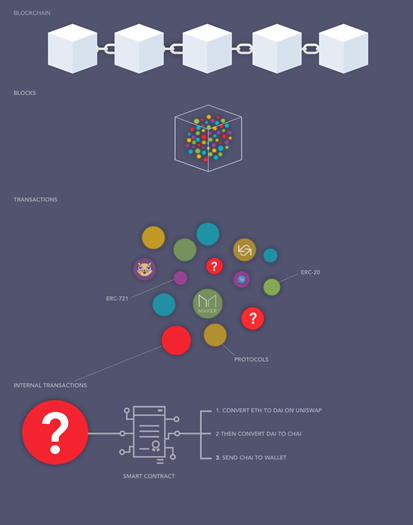

The above image (credits to [Blocknative](https://www.blocknative.com/)) details three internal transactions triggered by one transaction.

Thus diving deeper into the internal transactions of the stETH token contract would provide us with novel insights on how different protocols or services interact with Lido.

### Initial thoughts

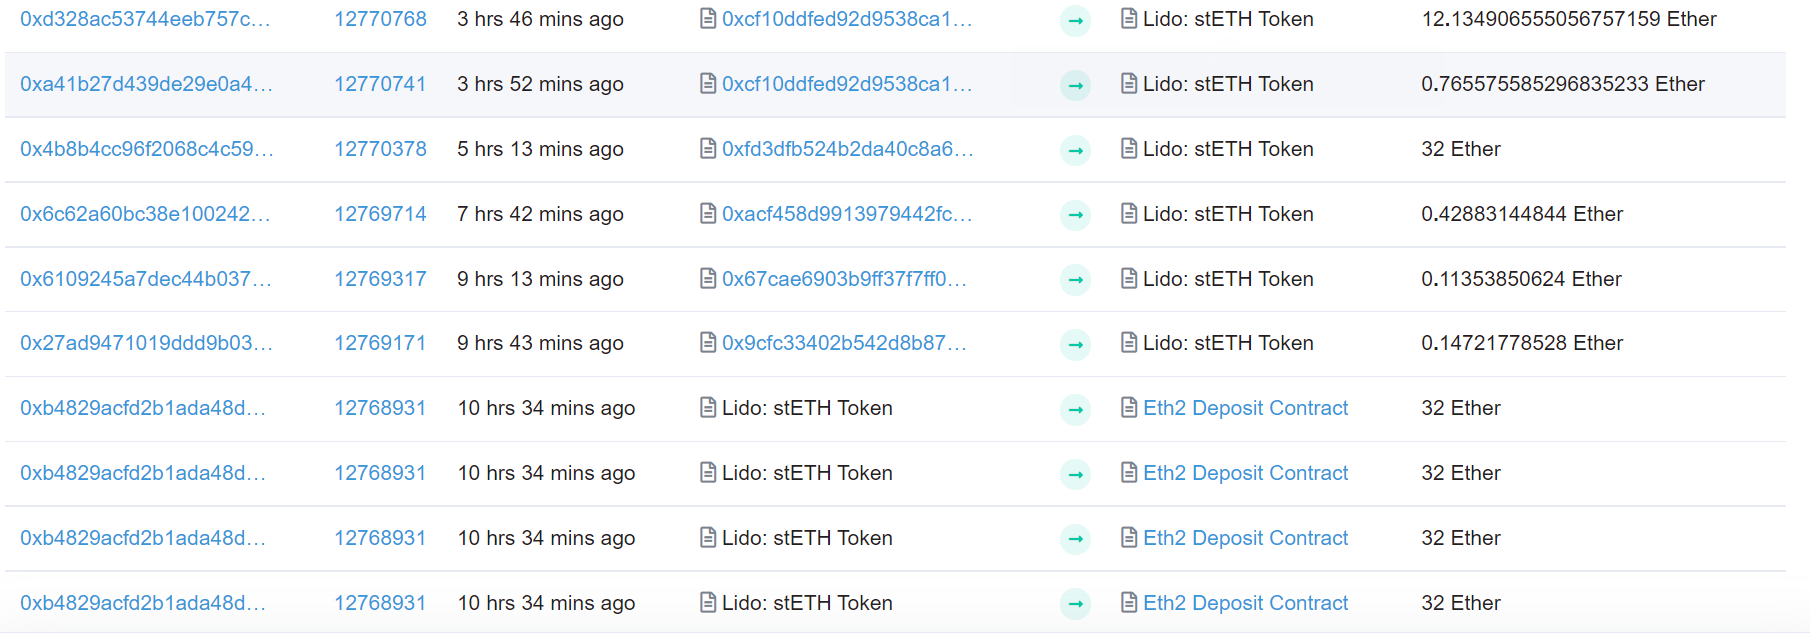

On first glance, we could say that there were roughly two types of internal transactions that were captured by the stETH token contract - the first where some amount of ETH was deposited to the contract and the second where deposits of 32 ETH were made to the official Ethereum Proof-of-Stake (PoS) deposit contract.

We collected data pertaining to the internal transactions using the CSV files uploaded on Etherscan. Since we also decided to use the web3 library for our analysis, we also needed to establish an active connection with an Ethereum node hosted on Infura, shown in the next few lines of code.

In [1]:
from web3 import Web3
import json
import requests
import csv
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from time import *
import plotly.express as px
import plotly.io as pio
pd.options.plotting.backend = "plotly"
pio.renderers.default = "plotly_mimetype+notebook_connected"
import plotly.graph_objects as go
import math
from datetime import datetime

In [10]:
with open('infura_url.txt', 'r') as file:
    infura_url = file.read()

web3 = Web3(Web3.HTTPProvider(infura_url))
web3.isConnected()

True

In [120]:
contract_address = web3.toChecksumAddress('0xae7ab96520de3a18e5e111b5eaab095312d7fe84')
abi = json.loads('[{"constant":true,"inputs":[],"name":"proxyType","outputs":[{"name":"proxyTypeId","type":"uint256"}],"payable":false,"stateMutability":"pure","type":"function"},{"constant":true,"inputs":[],"name":"isDepositable","outputs":[{"name":"","type":"bool"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"implementation","outputs":[{"name":"","type":"address"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"appId","outputs":[{"name":"","type":"bytes32"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"kernel","outputs":[{"name":"","type":"address"}],"payable":false,"stateMutability":"view","type":"function"},{"inputs":[{"name":"_kernel","type":"address"},{"name":"_appId","type":"bytes32"},{"name":"_initializePayload","type":"bytes"}],"payable":false,"stateMutability":"nonpayable","type":"constructor"},{"payable":true,"stateMutability":"payable","type":"fallback"},{"anonymous":false,"inputs":[{"indexed":false,"name":"sender","type":"address"},{"indexed":false,"name":"value","type":"uint256"}],"name":"ProxyDeposit","type":"event"}]')

In [2]:
df1 = pd.read_csv('import_file_1.csv', index_col=False, low_memory=False)
df2 = pd.read_csv('import_file_2.csv', index_col=False, low_memory=False)

frames = [df1, df2]
df = pd.concat(frames)

We notice a single transaction often makes multiple deposits of 32 ETH to the PoS deposit contract, thus we decided to prune the dataframe of internal transactions and remove all the entries with the same transaction hash.

In [3]:
df_pruned = df.drop_duplicates(subset = 'Txhash', keep = 'first')
print(len(df_pruned))

1856


As we see, there are 1856 unique transactions that we have to analyze.

In [4]:
deposit_transactions = df_pruned['TxTo'] == '0x00000000219ab540356cbb839cbe05303d7705fa'
stEth_token_transactions = df_pruned['TxTo'] == '0xae7ab96520de3a18e5e111b5eaab095312d7fe84' 
df_pruned_deposit_transactions = df_pruned[deposit_transactions]
df_pruned_stEth_token_transactions = df_pruned[stEth_token_transactions]
zero_value_transactions = df_pruned_stEth_token_transactions['Value_IN(ETH)'] == 0
df_pruned_zero_value_transactions = df_pruned_stEth_token_transactions[zero_value_transactions]
print(len(df_pruned_deposit_transactions))
print(len(df_pruned_stEth_token_transactions))
#print(len(df_pruned_zero_value_transactions))

195
1661


Out of these 1856 transactions, there are 195 deposit transactions.

Note here that we analyze the pruned databas, meaning that there are in reality a lot more than 195 deposits of 32 ETH made to the PoS deposit contract, since in many cases a single transaction triggers multiple deposits activating multiple validators.

In [5]:
df_pruned_deposit_transactions.to_csv('lido_deposits.csv', index = False)
df_pruned_stEth_token_transactions.to_csv('lido_stEth_token_transactions.csv', index = False)

In [6]:
txn_hash_deposit_transactions = df_pruned_deposit_transactions.iloc[:, 0]
data_list_eth2_deposits = []
txn_hash_stEth_token_transactions = df_pruned_stEth_token_transactions.iloc[:, 0]
data_list_stEth_token_transactions = []

To collect additional data on the parent transaction, we used the web3py library's `get_transaction` method

In [250]:
for i in txn_hash_deposit_transactions:
    #print(i)
    data_list_eth2_deposits.append(web3.eth.get_transaction(i))

In [251]:
for i in txn_hash_stEth_token_transactions:
    #print(i)
    data_list_stEth_token_transactions.append(web3.eth.get_transaction(i))

In [285]:
df_gas_deposits = pd.DataFrame(data_list_eth2_deposits)

df_gas_stEth_toekn_transactions = pd.DataFrame(data_list_stEth_token_transactions)

# print(df_deposit_transactions)
# print(df_stEth_token_transactions)

In [286]:
df_gas_deposits.to_csv('lido_deposits_with_gas.csv', index = False)
df_gas_stEth_toekn_transactions.to_csv('lido_stEth_token_transactions_with_gas.csv', index = False)

Once the final dataframe was ready for us to work with, the next step was to gain some novel insights into the process flow leading to deposit transactions made using the Lido protocol by seeing the unique From and To address pairs for these transactions. 

This would give us an idea on who triggers these deposits and would demistify the architecture set in place for making these deposits.

In [7]:
df_deposit_transactions_pairs = df_pruned_deposit_transactions.groupby(['ParentTxFrom','ParentTxTo', 'TxTo', 'From']).size().reset_index().rename(columns={0:'count'})
df_deposit_transactions_pairs.sort_values(["count"], ascending=False)

ParentTxFrom  \
2  0x6352f8c749954c9df198cf72976e48994a77cce2   
5  0xa76a7d0d06754e4fc4941519d1f9d56fd9f8d53b   
0  0x00444797ba158a7bdb8302e72da98dcbccef0fbc   
1  0x073adf97f6de257d76e67f7c2fe57ac9843cca25   
6  0xc8381ca290c198f5ab739a1841ce8aedb0b330d5   
3  0x6e34e47df7026e0ace9457f930f1cfada6f547c4   
4  0x99b2c5d50086b02f83e791633c5660fbb8344653   

                                   ParentTxTo  \
2  0x1ee5c83c4b43aaed21613d5cc7835d36078ce03f   
5  0xae7ab96520de3a18e5e111b5eaab095312d7fe84   
0  0xae7ab96520de3a18e5e111b5eaab095312d7fe84   
1  0xae7ab96520de3a18e5e111b5eaab095312d7fe84   
6  0xae7ab96520de3a18e5e111b5eaab095312d7fe84   
3  0x1ee5c83c4b43aaed21613d5cc7835d36078ce03f   
4  0x1ee5c83c4b43aaed21613d5cc7835d36078ce03f   

                                         TxTo  \
2  0x00000000219ab540356cbb839cbe05303d7705fa   
5  0x00000000219ab540356cbb839cbe05303d7705fa   
0  0x00000000219ab540356cbb839cbe05303d7705fa   
1  0x00000000219ab540356cbb839cbe05303d7705fa   
6  0x00000000219ab540356cbb839cbe05303d7705fa   
3  0x00000000219ab540356cbb839cbe05303d7705fa   
4  0x00000000219ab540356cbb839cbe05303d7705fa   

                                         From  count  
2  0xae7ab96520de3a18e5e111b5eaab095312d7fe84     72  
5  0xae7ab96520de3a18e5e111b5eaab095312d7fe84     53  
0  0xae7ab96520de3a18e5e111b5eaab095312d7fe84     36  
1  0xae7ab96520de3a18e5e111b5eaab095312d7fe84     25  
6  0xae7ab96520de3a18e5e111b5eaab095312d7fe84      5  
3  0xae7ab96520de3a18e5e111b5eaab095312d7fe84      3  
4  0xae7ab96520de3a18e5e111b5eaab095312d7fe84      1

## Inferences

Based on our finidings from the previous section, we were able to hypothesize a rough structural architecture diagram on how deposits work with Lido.

After taking a look at the results of our analysis, we can see that there exists 7 unique 'From' and 'To' address pairs which when they transact, triggers a deposit of 32 ETH to be made to the PoS deposit contract.

What is interesting here is that there are 2 distinct 'To' addresses - the first one being the StETH token contract and the other a contract that goes by the name 'Vyper_contract'

#### stETH Token contract 

On reading the contract [documentation](https://github.com/lidofinance/docs/blob/49db2ad064e7d759931e3a2e633a7a3a46e8330c/docs/contracts/lido.md), we identify that the method of interest to us is `depositBufferedEther()` which when called makes a deposit of 32 ETH to the PoS deposit contract. The ETH deposited is the ETH which is temporarily buffered in the contract. 

Thus, through this first channel we have 4 "depositors" (possibly Lido employees) with distinct wallet addresses invoking the `depositBufferedEther()` by sending a transaction of 0 Eth to the stETH token contract.

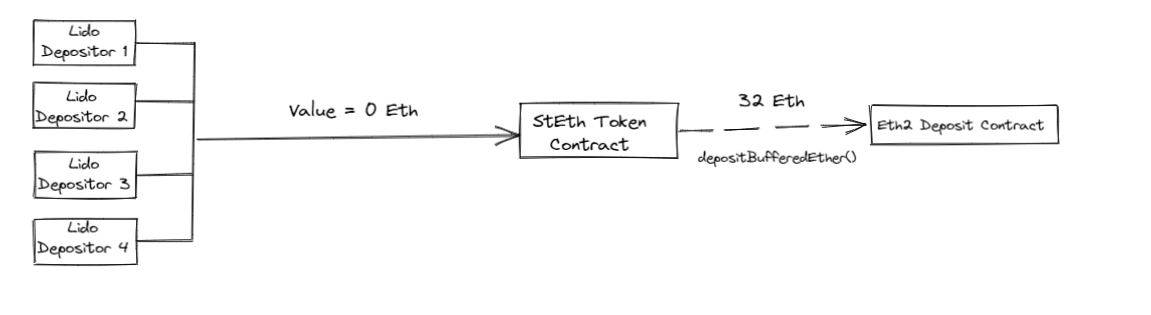

#### Vyper_contract

What is very interesting about this contract is the fact that it has a reference to KeeperDAO. A transaction to this contract also triggers a deposit through the same `depositBufferedEther()` function in the stETH contract since it has a reference to the same. 

The contract uses an assertion statement with the `isKeeper(address keeper) → bool` method to ensure that the person sending the message is a keeper (participants who execute available jobs in exchange for a reward in the Keep3r network).

Thus the way this is set up is, a keeper can directly use their ETH to activate new validators in the beacon chain rather than going through the regular endpoint that "normal" users would have to go through.

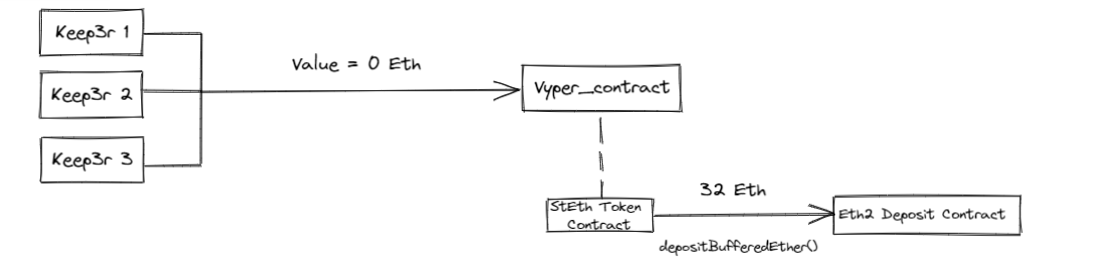

### Gas fees for transactions

In addition to our above analysis, we also look closer into the gas fees that were spent for making these deposits.

High transaction fees are an indicator of the network being busier with more people making transactions such as DEX trades or asset deposits.

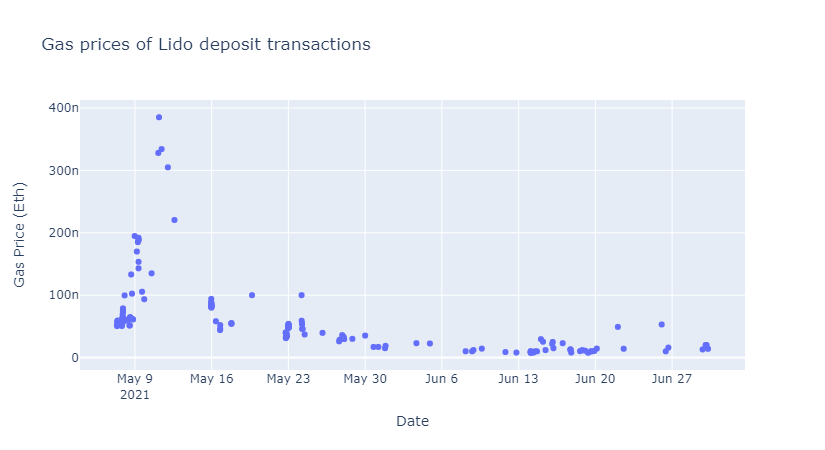

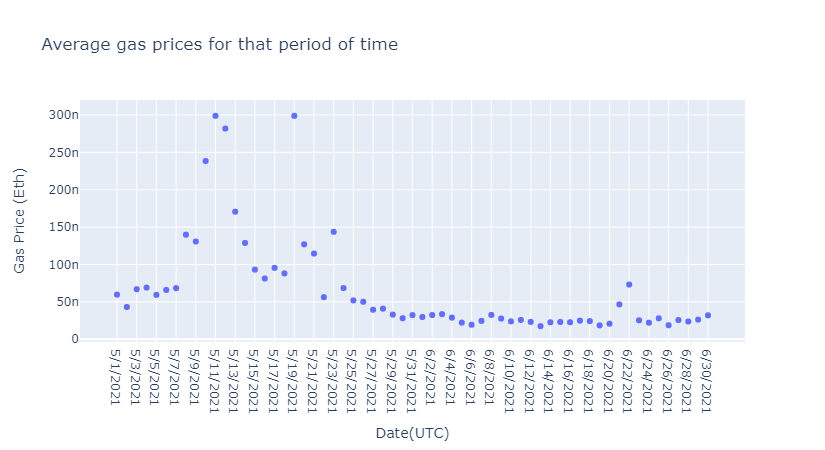

In [11]:
df_lido_deposits_with_gas = pd.read_csv("lido_deposits_with_gas.csv")
df_gas = pd.read_csv("gas_fee_data.csv")

# x = df_lido_deposits_with_gas["blockNumber"]
y = df_lido_deposits_with_gas["gasPrice"]
y1 = df_gas["Value (Wei)"]
lst = []
lst1 = []

#lst2 = []
x = df_lido_deposits_with_gas["blockNumber"] 

# for t in x:
#     temp = web3.eth.get_block(t)['timestamp']
#     lst2.append(datetime.fromtimestamp(temp))

for i in y:
    #lst.append(int(i)/(10**8))
    lst.append(Web3.fromWei(int(i), 'ether'))
for j in y1:
    lst1.append(Web3.fromWei(j, 'ether'))
fig = px.scatter(x = lst2 ,y = lst, title = "Gas prices of Lido deposit transactions")
fig.update_layout(xaxis_title = "Date", yaxis_title = "Gas Price (Eth)")
fig.show()
fig1 = px.scatter(x = df_gas["Date(UTC)"] ,y = lst1, title = "Average gas prices for that period of time")
fig1.update_layout(xaxis_title = "Date(UTC)", yaxis_title = "Gas Price (Eth)")
fig1.show()

Through the above graph we thus get more insights into roughly how much Lido spent on gas fees for these deposits and how they were distributed over time.

The trend that we notice is that the transaction fees really peaked soon after Lido first started activating validators. The gas fees during this period of time was quite high for the entire network as we see in the second graph plotted from data downloaded off Etherscan.

We also notice that for this period of time (around 10th - 15th May) Lido paid significantly higher gas fees when compared to the average (in some cases - 11th May, the difference was almost 100n) to get their transactions included on chain

However, the transaction fees gradually decreased to a value far lesser than the maximum value.

## The Beacon Chain Digest - July 7th 

Once again we continue our running analysis of the Beacon Chain through the lens of our 6 metrics. In this notebook, we take a look at epochs 45331 - 48480 (June 21, 7:18 AM GMT + 8 to Jul 5, 7:12 AM GMT + 8). As always we start off with collecting data and processing the data.

In [12]:
files = ["attestor_slashing", "proposer_slashing", "block_count", "participation_rate", "exit_count", "deposits"]
dfs = []

for file in files:
    df = pd.read_csv(f"{file}.csv", header=None, names=["epoch", file])
    df.dropna(subset=["epoch"], inplace=True)
    dfs += [df[[file]]] # We don't want the epoch column

df = pd.concat([df[["epoch"]]] + dfs, axis=1) # Concat everything, with the epoch column first
df["participation_rate"] *= 100 # Set to percentages
df = df[df.epoch < max(df["epoch"])] # Remove last epoch (queried too soon)
df["epoch"] = df["epoch"].astype(int)

### Attester and proposer slashing

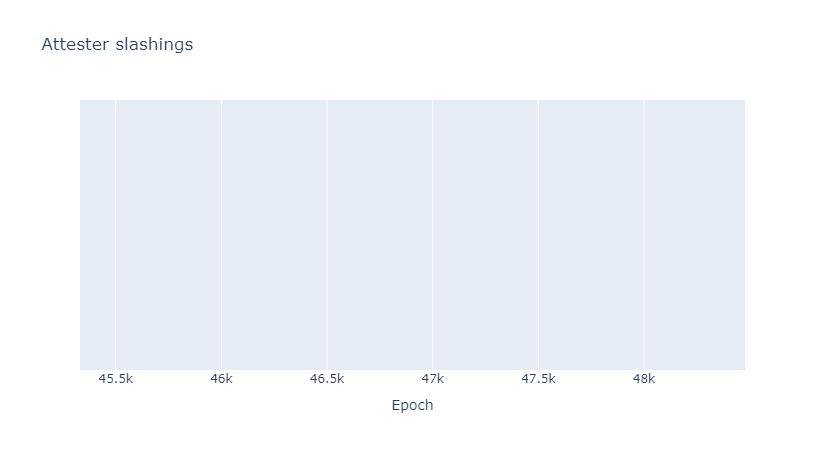

In [13]:
rng = np.random.default_rng(42)
df['temp'] = rng.uniform(0, 10, len(df["epoch"]))
fig = px.scatter(
    df[df.attestor_slashing > 0], x = 'epoch', y = 'temp', size = 'attestor_slashing',
    size_max = 20, labels = {"epoch": "Epoch"},
    title = f"Attester slashings"
)
fig.update_xaxes(range=(min(df["epoch"]), max(df["epoch"])))
fig.update_yaxes(visible=False)

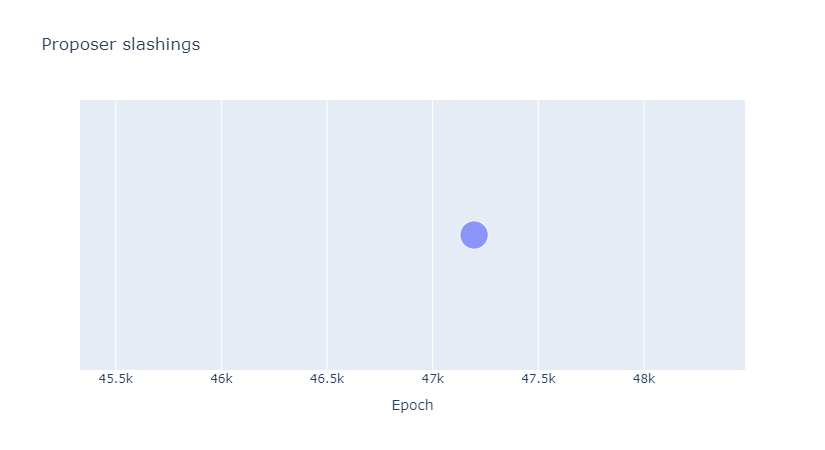

In [14]:
fig = px.scatter(
    df[df.proposer_slashing > 0], x = 'epoch', y = 'temp', size = 'proposer_slashing',
    size_max = 20, labels = {"epoch": "Epoch"},
    title = f"Proposer slashings"
)
fig.update_xaxes(range=(min(df["epoch"]), max(df["epoch"])))
fig.update_yaxes(visible=False)

Thus, we see that there has been 0 attestor slashing events and one proposer slashing event (for the first time ever since the inception of The Beacon Digest) at epoch 47196 where one proposer was slashed 

### Proposed block count

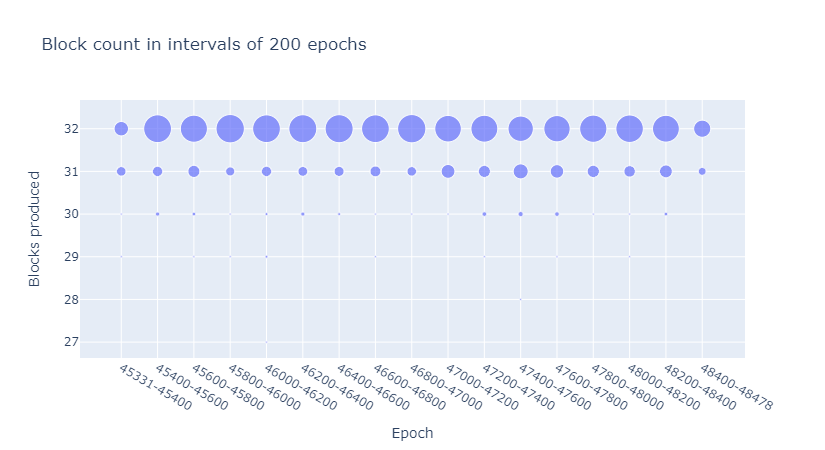

In [15]:
bucket_size = 200
df["bucket"] = np.floor_divide(df["epoch"], bucket_size)
df["n_bxs"] = 1
df_bucket = df[["bucket", "block_count", "n_bxs"]].groupby(["bucket", "block_count"]).sum("n_bxs").reset_index()
df_bucket["epoch"] = df_bucket.bucket.apply(
    lambda bucket: f"{max(min(df['epoch']), bucket * bucket_size)}-{min(max(df['epoch']), (bucket + 1) * bucket_size)}"
)

fig = px.scatter(df_bucket, x = 'epoch', y = 'block_count', size = 'n_bxs',
                 labels={ "block_count": "Blocks produced", "epoch": "Epoch", "n_bxs": "Count" },
                 title = f"Block count in intervals of {bucket_size} epochs")
fig

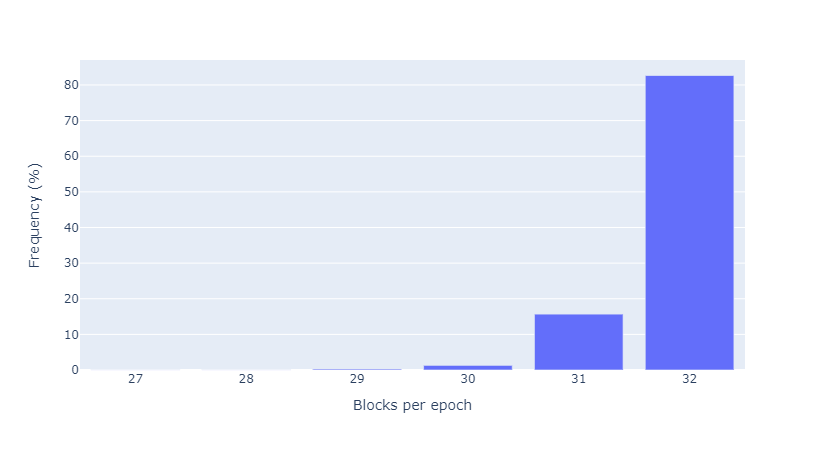

In [16]:
block_freq = df[['block_count']].value_counts(normalize=True).rename_axis('block_count').reset_index(name='freq')
block_freq["freq"] *= 100
px.bar(
    block_freq, x="block_count", y="freq", labels={"block_count": "Blocks per epoch", "freq": "Frequency (%)"}
)

We once again see that the network has been performing very well with regards to this metric and everything seems to be right on track. 

Around 82.6% of the time the number of blocks proposed per epoch was 32, around 15.7% of the time this number was 31 and around 1.6% of the time it was below 31.

### Participation rate

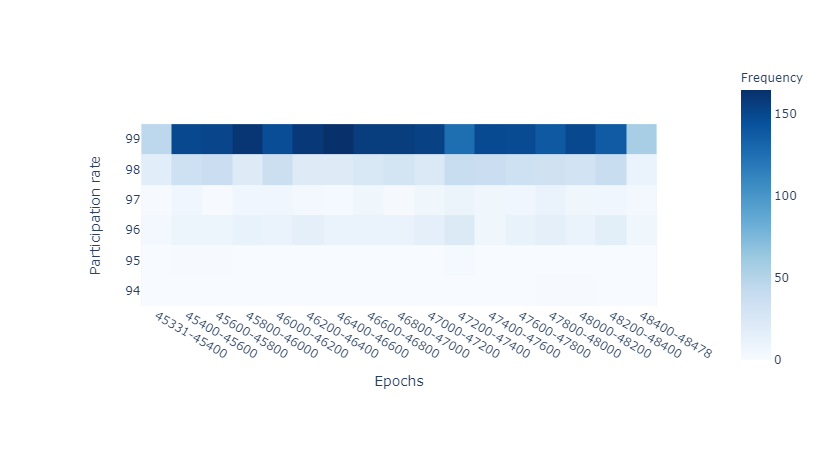

In [17]:
bins = pd.IntervalIndex.from_tuples([(i,i+1) for i in range(int(min(df["participation_rate"])), 100)][::-1])
df["participation_bin"] = pd.cut(df["participation_rate"], bins)
df_bucket = df[["bucket", "participation_bin", "n_bxs"]].groupby(["bucket", "participation_bin"]).sum("n_bxs").reset_index()
epoch_names = df_bucket.bucket.apply(
    lambda bucket: f"{max(min(df['epoch']), bucket * bucket_size)}-{min(max(df['epoch']), (bucket + 1) * bucket_size)}"
)
df_bucket["epoch"] = epoch_names
df_bucket = df_bucket[["participation_bin", "n_bxs", "epoch"]].pivot(index="participation_bin", columns=["epoch"])

px.imshow(
    df_bucket.to_numpy(),
    labels=dict(x="Epochs", y="Participation rate", color="Frequency"),
    x = sorted(list(set(epoch_names))),
    y = [str(s) for s in np.flip(np.arange(int(min(df["participation_rate"])), 100))],
    color_continuous_scale='blues'
)

In [18]:
mean = df['participation_rate'].mean()
std = df['participation_rate'].std()
mini = min(df['participation_rate'])
median = df['participation_rate'].quantile(0.5)
maxi = max(df['participation_rate'])

print("           participation statistics")
print("-----------------------------------------------")
print("mean: {}".format(mean))
print("standard devidation: {}".format(std))
print("")
print("minimum: {}".format(mini))
print("median: {}".format(median))
print("maximum: {}".format(maxi))

           participation statistics
-----------------------------------------------
mean: 99.0559773379996
standard devidation: 0.8162056384388161

minimum: 94.4651424884796
median: 99.37724471092224
maximum: 99.78379607200624


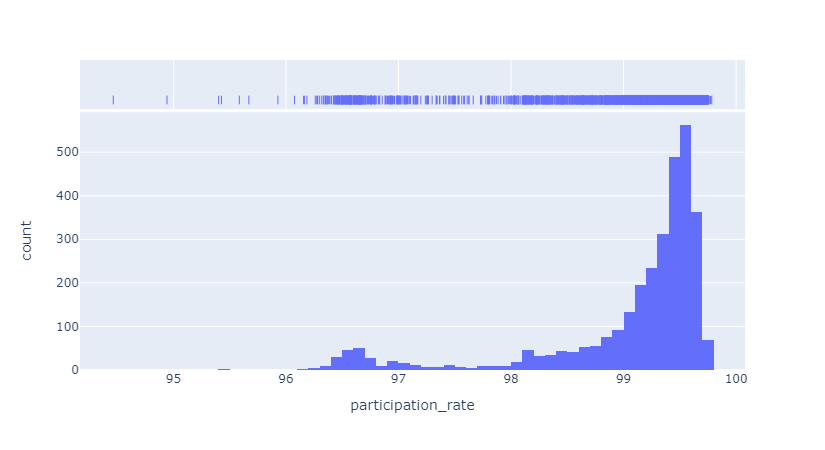

In [19]:
fig = px.histogram(df, x="participation_rate", marginal="rug")
fig.show()

Everything seems to be looking good with the network participation as well!

The participation rate of the network was the higher than unsual in the epoch range 46355 - 46725 and was the lower than usual in the epoch range 46388 - 45423, but the lowest participation rate was recorded at 48104.

The lowest participation rate for this range of epochs was around 94.46% (Significantly larger than the last fortnight's minimum) and the highest participation rate was at around 99.78% for this range of epochs. Once again, most epochs had a participation rate of >99%.

### Exit counts

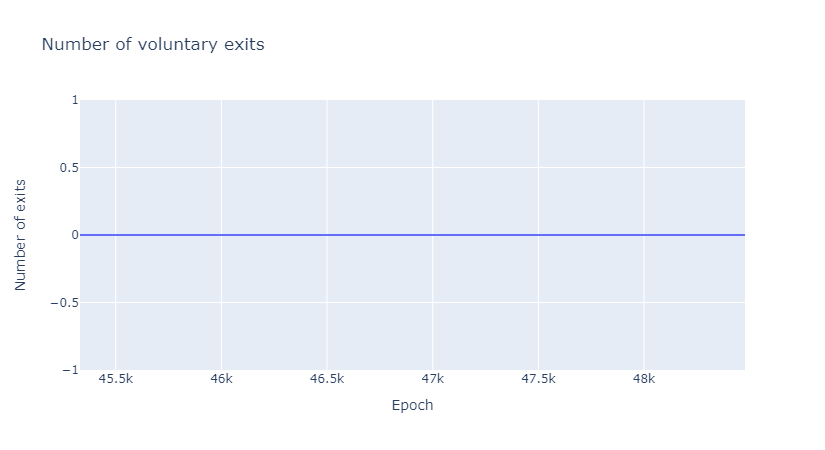

In [20]:
px.line(x=df['epoch'], y=df['exit_count'], labels = {"x": "Epoch", "y": "Number of exits"}, title = "Number of voluntary exits")

Thus, we see that once again there have been no exits among validators in this range of epochs.

### Deposit counts

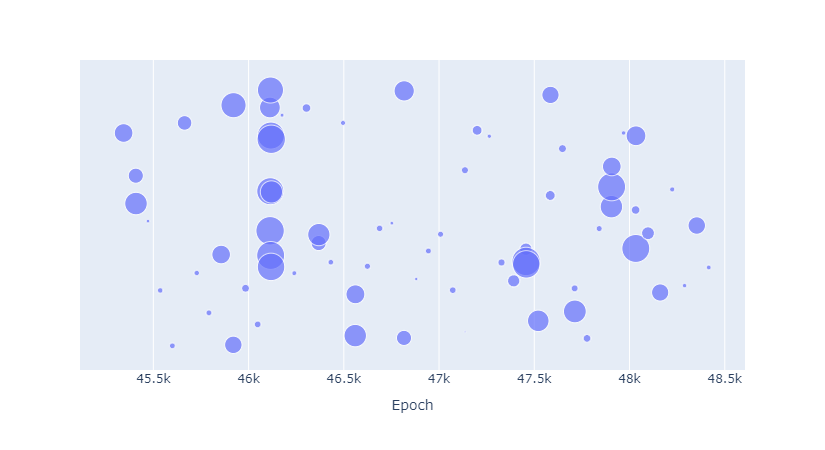

In [21]:
fig = px.scatter(
    df[df.deposits > 0], x = 'epoch', y = 'temp', size = 'deposits',
    size_max = 20, labels = {"epoch": "Epoch"})
fig.update_yaxes(visible=False)

An interesting trend that we notice for the deposits that were made to the beacon chain this fortnight is that were a lot of deposits in the range of 272 - 512 that are concentrated in a small range of epochs (46112 - 46118).

Apart from this small stretch most of the deposits seems to be somewhat evenly distributed throughout the all the epochs.